In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
df = pd.read_csv("covid_19_data.csv")
df.head()


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])

daily_country = df.groupby(["Country/Region", "ObservationDate"]).agg({
    "Confirmed": "sum",
    "Deaths": "sum",
    "Recovered": "sum"
}).reset_index()

latest = daily_country.sort_values("ObservationDate").groupby("Country/Region").tail(1)

latest["CFR"] = latest["Deaths"] / latest["Confirmed"].replace(0, np.nan)  # 病例致死率
latest["Active"] = latest["Confirmed"] - latest["Deaths"] - latest["Recovered"]
latest["ActiveRatio"] = latest["Active"] / latest["Confirmed"].replace(0, np.nan)


In [4]:
features = latest[["Confirmed", "Deaths", "Recovered", "CFR", "ActiveRatio"]].fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(features)


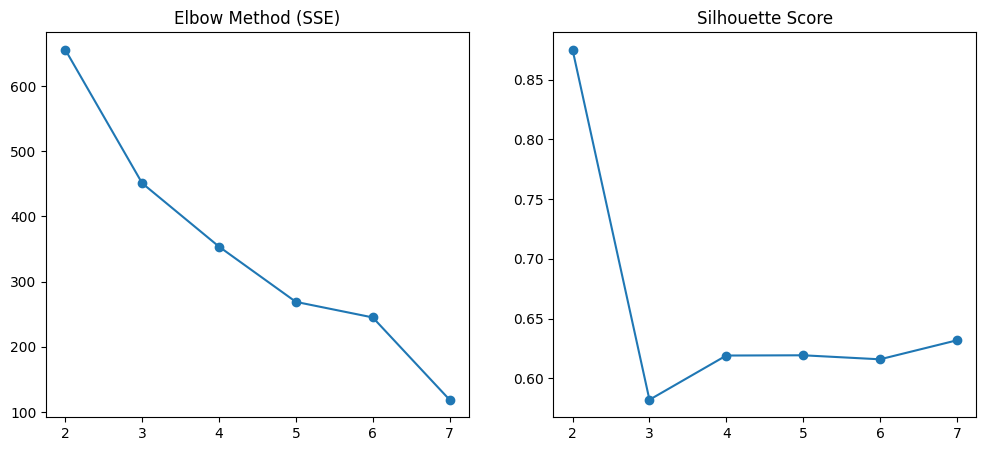

In [5]:
sse = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)  # SSE
    silhouette_scores.append(silhouette_score(X, km.labels_))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title("Elbow Method (SSE)")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.show()


In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
latest["Cluster_kmeans"] = kmeans.fit_predict(X)

latest[["Country/Region", "Cluster_kmeans"]].head(10)


,Country/Region,Cluster_kmeans
58667,North Ireland,2
0,Azerbaijan,2
64192,Republic of Ireland,2
74856,St. Martin,2
16296,China,0
84619,Vatican City,2
60556,Palestine,2
29798,Gibraltar,0
1,"('St. Martin',)",2
26092,Faroe Islands,2


In [7]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
latest["Cluster_hier"] = agg.fit_predict(X)

latest[["Country/Region", "Cluster_hier"]].head(10)


,Country/Region,Cluster_hier
58667,North Ireland,2
0,Azerbaijan,2
64192,Republic of Ireland,2
74856,St. Martin,2
16296,China,0
84619,Vatican City,2
60556,Palestine,2
29798,Gibraltar,0
1,"('St. Martin',)",2
26092,Faroe Islands,2


In [8]:
db = DBSCAN(eps=1.5, min_samples=3)
latest["Cluster_dbscan"] = db.fit_predict(X)

latest[latest["Cluster_dbscan"] == -1].head(10)


,Country/Region,ObservationDate,Confirmed,Deaths,Recovered,CFR,Active,ActiveRatio,Cluster_kmeans,Cluster_hier,Cluster_dbscan
35696,India,2021-05-29,27894800.0,325972.0,25454320.0,0.011686,2114508.0,0.075803,1,1,-1
10852,Brazil,2021-05-29,16471600.0,461057.0,14496224.0,0.027991,1514319.0,0.091935,1,1,-1
52682,Mexico,2021-05-29,2411503.0,223455.0,1924865.0,0.092662,263183.0,0.109137,0,0,-1
82156,US,2021-05-29,33251939.0,594306.0,0.0,0.017873,32657633.0,0.982127,1,1,-1


KMeans silhouette: 0.581949326678013
KMeans DB index: 0.5907477795794455


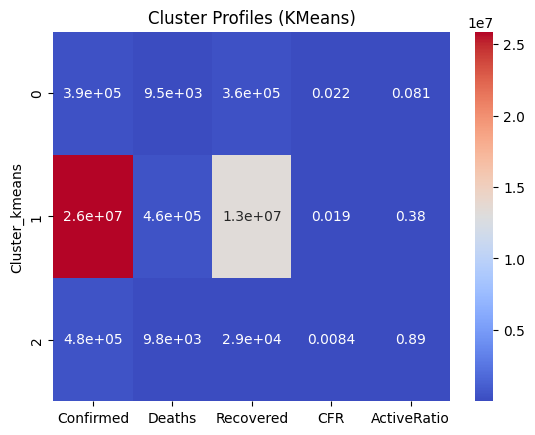

In [9]:
print("KMeans silhouette:", silhouette_score(X, latest["Cluster_kmeans"]))
print("KMeans DB index:", davies_bouldin_score(X, latest["Cluster_kmeans"]))

cluster_profile = latest.groupby("Cluster_kmeans")[["Confirmed", "Deaths", "Recovered", "CFR", "ActiveRatio"]].mean()
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm")
plt.title("Cluster Profiles (KMeans)")
plt.show()
